# Backtesting tool

[*********************100%***********************]  1 of 1 completed


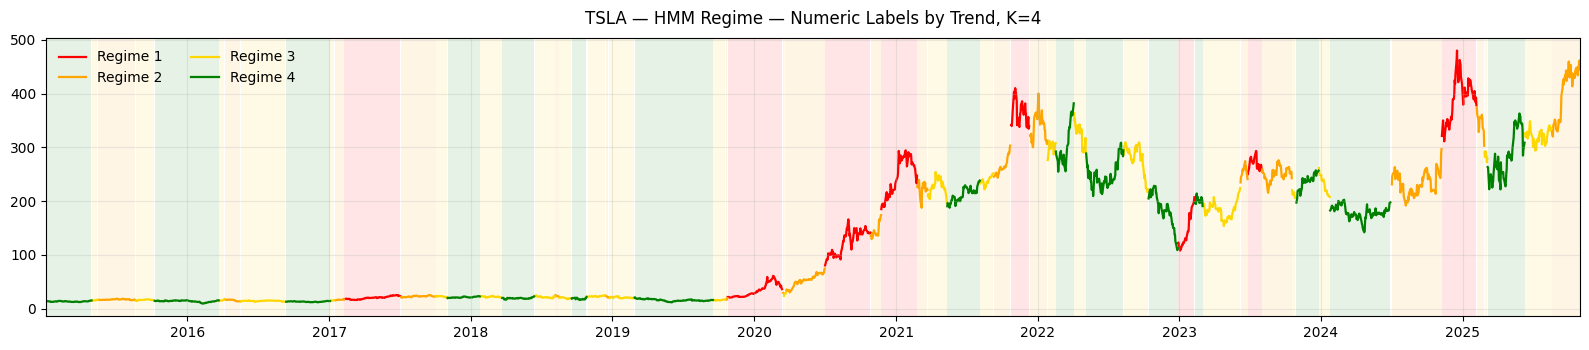


--- HMM Results (K=4) ---
Features Used: ['Level_ATR100', 'RSI']
Best log-likelihood: -4671.121719247361
   state  trend_score  mom_score  macd_score  ac1_5_score
0      2    34.175576   0.005962    0.018818          NaN
1      1    16.358981   0.010134   -0.052612          NaN
2      0     1.010016   0.939173   -0.369444          NaN
3      3   -13.016806  -0.046535    0.349432          NaN


In [444]:
from hmm_regime import HMMRegimeAnalyzer, with_regime_index

analyzer = HMMRegimeAnalyzer(
    ticker="TSLA",
    start="1995-01-01",
    plot_start="2015-01-01",
    n_states=4,
    n_trials=20,
    ma_window=120,
    rsi_period=14,
    ac_window=60,
    smoothing_window_mr=1,
    use_slope=False,
    use_ac=False,
    use_rsi=True,
    use_volume=False
)

df, feats_scaled, model, mapping = analyzer.run()
df_ix = with_regime_index(df)


In [445]:
import pandas as pd
import yfinance as yf

ticker = analyzer.ticker
start  = analyzer.start

# 1) 원시 다운로드 (멀티인덱스까지 고려)
raw = yf.download(ticker, start=start, auto_adjust=True, progress=False)

def _get_ohl_from_yf(df):
    """
    yfinance 단일 티커에서 생기는 케이스 모두 처리해서
    Open/High/Low 각각 1D Series로 리턴.
    """
    def _extract(field: str) -> pd.Series:
        if isinstance(df.columns, pd.MultiIndex):
            lvl0 = df.columns.get_level_values(0)
            lvl1 = df.columns.get_level_values(1)
            # case A: 레벨1에 필드명이 있는 경우
            if field in set(lvl1):
                s = df.xs(field, level=1, axis=1)
            # case B: 레벨0에 필드명이 있는 경우
            elif field in set(lvl0):
                s = df[field]
            else:
                raise KeyError(f"Cannot locate {field} in columns {df.columns}")
            # 단일 티커면 DF일 수 있으니 1D로 납작화
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
        else:
            s = df[field]
        return pd.to_numeric(s, errors='coerce').rename(field)

    O = _extract('Open')
    H = _extract('High')
    L = _extract('Low')
    return O, H, L

open_, high, low = _get_ohl_from_yf(raw)

# 2) df와 정렬 맞추고 결합 (df는 기존에 가지고 있던 가격/레짐 DF)
ohl = pd.concat([open_, high, low], axis=1).reindex(df.index)
df_aug = df.join(ohl)

# 3) 표준 컬럼명 보장 + 정렬
df_aug = df_aug.rename(columns={
    'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'Regime':'regime'
})
df_aug = df_aug[~df_aug.index.duplicated(keep='last')].sort_index()

# 4) 멀티인덱스 df_ix, 백테스트용 df_out 생성
df_ix = with_regime_index(df_aug)

df_out = (
    df_aug[['Close','Open','High','Low','regime']]
      .dropna(subset=['Close','Open','High','Low','regime'])
      .assign(regime=lambda x: x['regime'].astype(int))
      .sort_index()
)


In [446]:
df_out

,Close,Open,High,Low,regime
Date,,,,,
2010-08-24,1.280000,1.283333,1.314000,1.263333,3
2010-08-25,1.326667,1.277333,1.332000,1.237333,3
2010-08-26,1.316667,1.326000,1.351333,1.306667,3
2010-08-27,1.313333,1.316667,1.324667,1.300000,3
2010-08-30,1.324667,1.313333,1.346000,1.307333,3
...,...,...,...,...,...
2025-10-24,433.720001,446.829987,451.679993,430.170013,2
2025-10-27,452.420013,439.980011,460.160004,438.690002,2
2025-10-28,460.549988,454.779999,467.000000,451.600006,2


In [447]:
# =========================================
# 0) Imports & 타입 유틸
# =========================================
import numpy as np
import pandas as pd
import numbers
from dataclasses import dataclass
from typing import Callable, Dict, Optional, Iterable
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from pandas.api.types import is_integer_dtype, is_float_dtype

# =========================================
# 1) 레짐 맵 & 문자열 → 시그널 변환
# =========================================
REGIME_MAP = {"Momentum": 1, "MeanReversion": -1, "RandomWalk": 0}

def map_regime_to_signal(regime: pd.Series) -> pd.Series:
    """
    df_out['regime'](str|int|float|np.int64 등)을 {-1,0,1}로 변환.
    """
    def _norm(x):
        if isinstance(x, numbers.Real) and x in (-1, 0, 1):
            return int(x)
        key = str(x).strip().lower().replace("_","")
        if key in ("momentum", "momo"): return 1
        if key in ("meanreversion", "mean-reversion", "mr"): return -1
        if key in ("randomwalk", "rw"): return 0
        return np.nan
    return regime.map(_norm).astype(float)

# =========================================
# 2) 설정 & 유틸
# =========================================
@dataclass
class BTConfig:
    init_capital: float = 1_000_000.0
    fee_bps: float = 5.0
    slip_bps: float = 0.0
    max_leverage: float = 1.0
    allow_shorts: bool = True
    # 전략 파라미터(기본값)
    mom_lookback: int = 20
    mr_z_window: int = 60
    mr_smooth: int = 10

def _bps_to_decimal(bps: float) -> float:
    return bps / 10_000.0

def clip_leverage(sig: pd.Series, max_leverage: float, allow_shorts: bool) -> pd.Series:
    if not allow_shorts:
        sig = sig.clip(lower=0)
    return sig.clip(-max_leverage, max_leverage)

# =========================================
# 3) 전략 정의
# =========================================
def strat_momentum(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    p = prices.astype(float)
    r = returns.astype(float).fillna(0.0)
    eps = 1e-12

    L_fast   = int(max(5,  getattr(cfg, "mom_lookback_fast", getattr(cfg, "mom_lookback", 60))))
    L_slow   = int(max(L_fast+1, getattr(cfg, "mom_lookback_slow", 120)))
    vol_win  = int(max(10, getattr(cfg, "mom_vol_window", 20)))
    z_cap    = float(getattr(cfg, "mom_z_cap", 3.0))
    thr_entry = float(getattr(cfg, "mom_entry", 0.25))
    thr_exit  = float(getattr(cfg, "mom_exit", 0.05))
    trend_win = int(max(20, getattr(cfg, "mom_trend_window", 100)))
    smooth    = int(max(1, getattr(cfg, "mom_smooth", getattr(cfg, "mr_smooth", 1))))
    w_fast = float(getattr(cfg, "mom_fast_weight", 0.5))
    w_slow = 1.0 - w_fast

    m_fast = r.rolling(L_fast, min_periods=L_fast).sum()
    m_slow = r.rolling(L_slow, min_periods=L_slow).sum()
    raw_mom = w_fast * m_fast + w_slow * m_slow

    vol = r.rolling(vol_win, min_periods=max(5, vol_win//2)).std()
    score = (raw_mom / (vol + eps)).clip(-z_cap, z_cap)

    sma_long = p.rolling(trend_win, min_periods=max(5, trend_win//2)).mean()
    trend_long = (p >= sma_long).astype(float) - (p < sma_long).astype(float)

    score_tf = score.copy()
    score_tf = score_tf.mask((score > 0) & (trend_long < 0), np.nan)
    score_tf = score_tf.mask((score < 0) & (trend_long > 0), np.nan)

    raw_enter = pd.Series(
        np.where(score_tf >=  thr_entry,  1.0, np.where(score_tf <= -thr_entry, -1.0, np.nan)),
        index=score_tf.index, dtype=float
    )
    raw_hyst = raw_enter.copy()
    raw_hyst = raw_hyst.mask((raw_hyst > 0) & (score_tf <=  thr_exit), np.nan)
    raw_hyst = raw_hyst.mask((raw_hyst < 0) & (score_tf >= -thr_exit), np.nan)

    if smooth > 1:
        sm = pd.Series(raw_hyst, index=score_tf.index).ewm(span=smooth, adjust=False, min_periods=1).mean()
        raw_hyst = np.sign(sm).replace(0, np.nan)

    sig = pd.Series(raw_hyst, index=score_tf.index).ffill().fillna(0.0)
    return clip_leverage(sig, cfg.max_leverage, cfg.allow_shorts)

def strat_mean_reversion(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    p = prices.astype(float); eps = 1e-12
    rsi_period   = int(max(2, getattr(cfg, "mr_rsi_period", 14)))
    low_th       = float(getattr(cfg, "mr_rsi_low", 30.0))
    high_th      = float(getattr(cfg, "mr_rsi_high", 70.0))
    pad          = float(getattr(cfg, "mr_rsi_entry_pad", 5.0))
    z_win        = int(max(5, getattr(cfg, "mr_z_window", 20)))
    smooth_span  = int(max(1, getattr(cfg, "mr_smooth", 1)))
    trend_mult   = float(getattr(cfg, "mr_trend_mult", 3.0))
    vol_floor    = float(getattr(cfg, "mr_vol_floor", 0.0025))

    delta = p.diff()
    gain  = delta.clip(lower=0.0)
    loss  = (-delta).clip(lower=0.0)
    alpha = 1.0 / rsi_period
    avg_gain = gain.ewm(alpha=alpha, adjust=False, min_periods=rsi_period).mean()
    avg_loss = loss.ewm(alpha=alpha, adjust=False, min_periods=rsi_period).mean()
    rs  = avg_gain / (avg_loss + eps)
    rsi = (100.0 - (100.0 / (1.0 + rs))).clip(1.0, 99.0)

    low_entry, low_exit   = max(1.0, low_th),  min(50.0, low_th + pad)
    high_entry, high_exit = min(99.0, high_th), max(50.0, high_th - pad)

    sma_long  = p.rolling(3 * z_win, min_periods=max(3, z_win)).mean()
    price_vol = (p.pct_change().rolling(z_win, min_periods=max(3, z_win//2)).std() * p.shift(1)).clip(lower=vol_floor)
    z_dev = (p - sma_long).abs() / (price_vol + eps)
    trend_block = (z_dev > trend_mult)

    idx = p.index
    pos = np.zeros(len(idx), dtype=float)
    cur = 0.0
    for i, t in enumerate(idx):
        if trend_block.iloc[i]:
            cur = 0.0; pos[i] = 0.0; continue
        r = rsi.iloc[i]
        if cur == 0.0:
            if r <= low_entry: cur = 1.0
            elif r >= high_entry: cur = -1.0
        elif cur > 0.0:
            if r >= low_exit: cur = 0.0
        else:
            if r <= high_exit: cur = 0.0
        pos[i] = cur

    sig = pd.Series(pos, index=idx, dtype=float)
    if smooth_span > 1:
        sm = sig.ewm(span=smooth_span, adjust=False, min_periods=1).mean()
        sig = np.sign(sm).replace(0, 0.0)
    return clip_leverage(sig, cfg.max_leverage, cfg.allow_shorts)

def strat_random_walk(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    return pd.Series(0.0, index=prices.index)

# =========================================
# 4) 트레일링 스탑 (ATR/퍼센트 + 초기 하드스톱 + 무장조건)
# =========================================
def apply_trailing_stop(
    prices: pd.Series,
    pos_exec: pd.Series,
    trail_pct: Optional[float] = None,
    cool_off_days: int = 0,
    *,
    highs: Optional[pd.Series] = None,
    lows: Optional[pd.Series]  = None,
    atr: Optional[pd.Series]   = None,
    k_atr: Optional[float]     = None,
    stop_exec_shift: int = 1,
    forbid_samebar_reentry: bool = True,
    execute_on_trigger_close: bool = False,
    min_gain_to_trail_atr: float = 0.0,
    # ====== 신규 옵션: 초기 하드스톱 ======
    initial_k_atr: Optional[float] = None,     # 예) 2.0 → 진입가 ± 2 * ATR(진입시)
    initial_pct: Optional[float] = None,       # 예) 0.03 → 진입가 ± 3%
    arm_after_bars: int = 0,                   # 트레일 무장까지 최소 바 수
    hard_stop_use_entry_atr: bool = True       # True면 진입 시 ATR 고정, False면 매 바 ATR
):
    idx = pos_exec.index
    P = prices.reindex(idx).astype(float)
    H = highs.reindex(idx).astype(float) if highs is not None else P
    L = lows.reindex(idx).astype(float)  if lows  is not None else P

    use_atr = (atr is not None) and (k_atr is not None)
    if use_atr:
        ATR = atr.reindex(idx).astype(float).fillna(method="ffill")
        k = float(k_atr)
    else:
        if trail_pct is None:
            raise ValueError("trail_pct 또는 (atr & k_atr) 중 하나는 반드시 지정해야 합니다.")
        tp = float(trail_pct)

    pos_out = pos_exec.copy().astype(float)

    cur_pos = 0.0
    entry_price = None
    entry_px_at_entry_bar = None
    entry_atr = None              # ★ 진입 시 ATR 저장
    bars_since_entry = 0          # ★ 진입 후 경과 바 수

    peak = None; trough = None
    last_stop = None
    cooldown = 0
    stop_pending = 0
    pending_side = None
    pending_stop_px = None
    logs_trigger = []; logs_exec = []

    for i, t in enumerate(idx):
        desired = float(pos_exec.iloc[i])
        px, hi, lo = P.iloc[i], H.iloc[i], L.iloc[i]

        # 예약 체결
        if stop_pending > 0:
            stop_pending -= 1
            if stop_pending == 0:
                pos_out.iloc[i] = 0.0
                cur_pos = 0.0
                entry_price = None
                entry_px_at_entry_bar = None
                entry_atr = None
                peak = trough = None
                last_stop = None
                cooldown = cool_off_days
                logs_exec.append({"time": t, "price": px, "stop_price": pending_stop_px, "side": pending_side})
                pending_side = None; pending_stop_px = None
                if forbid_samebar_reentry:
                    continue

        # 쿨다운
        if cooldown > 0:
            pos_out.iloc[i] = 0.0
            cooldown -= 1
            continue

        # 신규 진입
        if cur_pos == 0.0 and desired != 0.0:
            cur_pos = desired
            entry_price = px
            entry_px_at_entry_bar = px
            entry_atr = (ATR.iloc[i] if use_atr else None)   # ★ 저장
            bars_since_entry = 0
            peak = hi; trough = lo; last_stop = None
            pos_out.iloc[i] = desired
            continue


        # 보유 중 → 스톱 계산/판정
        # 보유 중 → 스톱 계산/판정
        if cur_pos != 0.0:
            # ====== 트레일 '무장' 조건: (ATR이익 기준) OR (진입 후 바 수 기준) ======
            armed_gain = True
            if use_atr and (min_gain_to_trail_atr is not None) and (min_gain_to_trail_atr > 0) and (entry_px_at_entry_bar is not None):
                if cur_pos > 0:
                    gain = (px - entry_px_at_entry_bar) / (ATR.iloc[i] + 1e-12)
                else:
                    gain = (entry_px_at_entry_bar - px) / (ATR.iloc[i] + 1e-12)
                armed_gain = (gain >= float(min_gain_to_trail_atr))

            # bars 기준 무장: None이면 이 조건 비활성화
            if arm_after_bars is None:
                armed_bars = False
            else:
                try:
                    armed_bars = (bars_since_entry >= max(0, int(arm_after_bars)))
                except Exception:
                    # 혹시 잘못된 타입이 들어오면 bars 기준은 비활성화
                    armed_bars = False

            armed = (armed_gain or armed_bars)

            # ====== (이하 기존 LONG/SHORT 트레일링 로직 동일) ======
            if armed:
                if cur_pos > 0:
                    peak = max(peak, hi) if peak is not None else hi
                    raw_stop = (peak - k * ATR.iloc[i]) if use_atr else (peak * (1.0 - tp))
                    stop_price = raw_stop if last_stop is None else max(last_stop, raw_stop)
                    triggered = (lo <= stop_price)
                    if triggered:
                        logs_trigger.append({"time": t, "price": px, "stop_price": stop_price, "side": "LONG"})
                        if execute_on_trigger_close:
                            pos_out.iloc[i] = 0.0
                            cur_pos = 0.0
                            entry_price = None
                            entry_px_at_entry_bar = None
                            peak = trough = None
                            last_stop = None
                            cooldown = cool_off_days
                            logs_exec.append({"time": t, "price": px, "stop_price": stop_price, "side": "LONG"})
                            if forbid_samebar_reentry:
                                continue
                        else:
                            stop_pending = max(1, int(stop_exec_shift))
                            pending_side = "LONG"; pending_stop_px = stop_price
                            pos_out.iloc[i] = cur_pos
                            continue
                    last_stop = stop_price
                else:
                    trough = min(trough, lo) if trough is not None else lo
                    raw_stop = (trough + k * ATR.iloc[i]) if use_atr else (trough * (1.0 + tp))
                    stop_price = raw_stop if last_stop is None else min(last_stop, raw_stop)
                    triggered = (hi >= stop_price)
                    if triggered:
                        logs_trigger.append({"time": t, "price": px, "stop_price": stop_price, "side": "SHORT"})
                        if execute_on_trigger_close:
                            pos_out.iloc[i] = 0.0
                            cur_pos = 0.0
                            entry_price = None
                            entry_px_at_entry_bar = None
                            peak = trough = None
                            last_stop = None
                            cooldown = cool_off_days
                            logs_exec.append({"time": t, "price": px, "stop_price": stop_price, "side": "SHORT"})
                            if forbid_samebar_reentry:
                                continue
                        else:
                            stop_pending = max(1, int(stop_exec_shift))
                            pending_side = "SHORT"; pending_stop_px = stop_price
                            pos_out.iloc[i] = cur_pos
                            continue
                    last_stop = stop_price


            # ===== 트레일링 스톱(무장 후) =====
            if armed:
                if cur_pos > 0:
                    peak = max(peak, hi) if peak is not None else hi
                    raw_stop = (peak - k * ATR.iloc[i]) if use_atr else (peak * (1.0 - tp))
                    stop_price = raw_stop if last_stop is None else max(last_stop, raw_stop)
                    triggered = (lo <= stop_price)
                    if triggered:
                        logs_trigger.append({"time": t, "price": px, "stop_price": stop_price, "side": "LONG"})
                        if execute_on_trigger_close:
                            pos_out.iloc[i] = 0.0
                            cur_pos = 0.0
                            entry_price = None
                            entry_px_at_entry_bar = None
                            entry_atr = None
                            peak = trough = None
                            last_stop = None
                            cooldown = cool_off_days
                            logs_exec.append({"time": t, "price": px, "stop_price": stop_price, "side": "LONG"})
                            if forbid_samebar_reentry:
                                continue
                        else:
                            stop_pending = max(1, int(stop_exec_shift))
                            pending_side = "LONG"; pending_stop_px = stop_price
                            pos_out.iloc[i] = cur_pos
                            continue
                    last_stop = stop_price
                else:
                    trough = min(trough, lo) if trough is not None else lo
                    raw_stop = (trough + k * ATR.iloc[i]) if use_atr else (trough * (1.0 + tp))
                    stop_price = raw_stop if last_stop is None else min(last_stop, raw_stop)
                    triggered = (hi >= stop_price)
                    if triggered:
                        logs_trigger.append({"time": t, "price": px, "stop_price": stop_price, "side": "SHORT"})
                        if execute_on_trigger_close:
                            pos_out.iloc[i] = 0.0
                            cur_pos = 0.0
                            entry_price = None
                            entry_px_at_entry_bar = None
                            entry_atr = None
                            peak = trough = None
                            last_stop = None
                            cooldown = cool_off_days
                            logs_exec.append({"time": t, "price": px, "stop_price": stop_price, "side": "SHORT"})
                            if forbid_samebar_reentry:
                                continue
                        else:
                            stop_pending = max(1, int(stop_exec_shift))
                            pending_side = "SHORT"; pending_stop_px = stop_price
                            pos_out.iloc[i] = cur_pos
                            continue
                    last_stop = stop_price

        # 미트리거 → 레짐 신호
        pos_out.iloc[i] = desired

        # 상태 업데이트(교차/청산/재진입)
        if cur_pos == 0.0 and desired != 0.0:
            cur_pos = desired
            entry_price = px
            entry_px_at_entry_bar = px
            entry_atr = (ATR.iloc[i] if use_atr else None)
            bars_since_entry = 0
            peak = hi; trough = lo; last_stop = None
        elif desired == 0.0 and cur_pos != 0.0:
            cur_pos = 0.0
            entry_price = None
            entry_px_at_entry_bar = None
            entry_atr = None
            bars_since_entry = 0
            peak = trough = None
            last_stop = None
        elif np.sign(desired) != np.sign(cur_pos):
            cur_pos = desired
            entry_price = px
            entry_px_at_entry_bar = px
            entry_atr = (ATR.iloc[i] if use_atr else None)
            bars_since_entry = 0
            peak = hi; trough = lo; last_stop = None

        # 보유 중이면 바 카운트 증가
        if cur_pos != 0.0:
            bars_since_entry += 1

    trail_log = (pd.DataFrame(logs_exec).set_index("time")
                 if logs_exec else pd.DataFrame(columns=["time","price","stop_price","side"]))
    return pos_out, trail_log

# =========================================
# 5) 보조 유틸
# =========================================
def _round_trips_from_trades(result: pd.DataFrame, trades: pd.DataFrame, exec_shift: int = 0):
    if trades.empty:
        return pd.DataFrame(columns=["entry_time","exit_time","side","entry_price","exit_price","ret_trade"])
    tr = trades.copy().sort_index()
    res = result.copy()
    res["one_plus_net"] = 1.0 + res["net"]
    rows = []
    entry_time = None; entry_price = None
    for t, row in tr.iterrows():
        prev_p, new_p, price = row["prev_pos"], row["new_pos"], row["price"]
        if prev_p != 0.0 and new_p != 0.0 and np.sign(prev_p) != np.sign(new_p):
            if entry_time is not None:
                s = res.index.get_loc(entry_time); e = res.index.get_loc(t)
                start = s if exec_shift == 0 else s + 1; end = e
                r = res["one_plus_net"].iloc[start:end+1].prod() - 1.0 if start <= end else 0.0
                rows.append({"entry_time": entry_time, "exit_time": t,
                             "side": "LONG" if prev_p > 0 else "SHORT",
                             "entry_price": entry_price, "exit_price": price, "ret_trade": r})
            entry_time = t; entry_price = price; continue
        if prev_p == 0.0 and new_p != 0.0:
            entry_time = t; entry_price = price
        elif prev_p != 0.0 and new_p == 0.0:
            if entry_time is not None:
                s = res.index.get_loc(entry_time); e = res.index.get_loc(t)
                start = s if exec_shift == 0 else s + 1; end = e
                r = res["one_plus_net"].iloc[start:end+1].prod() - 1.0 if start <= end else 0.0
                rows.append({"entry_time": entry_time, "exit_time": t,
                             "side": "LONG" if prev_p > 0 else "SHORT",
                             "entry_price": entry_price, "exit_price": price, "ret_trade": r})
            entry_time = None; entry_price = None
    return pd.DataFrame(rows, columns=["entry_time","exit_time","side","entry_price","exit_price","ret_trade"])

def _normalize_window(idx: pd.DatetimeIndex, start: Optional[str], end: Optional[str]) -> pd.DatetimeIndex:
    if not isinstance(idx, pd.DatetimeIndex):
        raise TypeError("Index must be a DatetimeIndex")
    idx_mon = pd.DatetimeIndex(idx).sort_values().unique()
    tz = idx_mon.tz
    s = pd.to_datetime(start) if start else None
    e = pd.to_datetime(end)   if end   else None
    if tz is not None:
        if s is not None and s.tzinfo is None: s = s.tz_localize(tz)
        if e is not None and e.tzinfo is None: e = e.tz_localize(tz)
    else:
        if s is not None and s.tzinfo is not None: s = s.tz_convert(None)
        if e is not None and e.tzinfo is not None: e = e.tz_convert(None)
    mask = pd.Series(True, index=idx_mon)
    if s is not None: mask &= (idx_mon >= s)
    if e is not None: mask &= (idx_mon <= e)
    return idx_mon[mask]

# =========================================
# 6) 코어: backtest_regime_switch
# =========================================
def backtest_regime_switch(
    prices: pd.Series,
    regime_signal: Optional[pd.Series] = None,
    *,
    regime_num: Optional[pd.Series] = None,
    strategy_map: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
    start: Optional[str] = None, end: Optional[str] = None,
    warmup_bars: int = 100,
    highs: Optional[pd.Series] = None, lows: Optional[pd.Series]  = None,
    atr: Optional[pd.Series]   = None, k_atr: Optional[float]     = None,
    config: Optional[BTConfig] = None, custom_strategies: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
    exec_shift: int = 0,
    prob_gate: Optional[pd.Series] = None, prob_threshold: float = 0.0,
    trail_pct: Optional[float] = 0.05, cool_off_days: int = 0,
    fee_bps: Optional[float] = None, slip_bps: Optional[float] = None,
    execute_on_trigger_close: bool = False,
    min_gain_to_trail_atr: float = 0.0,
    # ★ 신규 옵션 전달
    initial_k_atr: Optional[float] = None,
    initial_pct: Optional[float] = None,
    arm_after_bars: int = 0,
    hard_stop_use_entry_atr: bool = True,
) -> Dict[str, pd.DataFrame]:

    cfg = (config or BTConfig())
    if fee_bps is not None: cfg.fee_bps = float(fee_bps)
    if slip_bps is not None: cfg.slip_bps = float(slip_bps)

    # 윈도우/워밍업
    full_idx = pd.DatetimeIndex(prices.index).sort_values().unique()
    win_idx  = _normalize_window(full_idx, start, end)
    if start or end:
        if len(win_idx) == 0: raise ValueError("선택한 기간에 데이터가 없습니다.")
        start_pos = full_idx.get_indexer([win_idx.min()], method="nearest")[0]
        end_pos   = full_idx.get_indexer([win_idx.max()], method="nearest")[0]
        calc_idx  = full_idx[max(0, start_pos - warmup_bars) : end_pos + 1]
    else:
        win_idx = full_idx; calc_idx = full_idx

    # ★ 모든 입력 reindex(중요)
    prices = pd.to_numeric(pd.Series(prices).reindex(calc_idx), errors="coerce").astype(float)
    if highs is not None: highs = pd.to_numeric(pd.Series(highs).reindex(calc_idx), errors="coerce").astype(float)
    if lows  is not None: lows  = pd.to_numeric(pd.Series(lows ).reindex(calc_idx), errors="coerce").astype(float)
    if atr   is not None: atr   = pd.to_numeric(pd.Series(atr  ).reindex(calc_idx), errors="coerce").astype(float)
    if regime_signal is not None: regime_signal = pd.Series(regime_signal).reindex(calc_idx)
    if regime_num is not None:    regime_num    = pd.Series(regime_num).reindex(calc_idx)
    if prob_gate is not None:     prob_gate     = pd.Series(prob_gate).reindex(calc_idx)

    # 수익률
    ret = prices.pct_change().fillna(0.0)

    # 전략 디스패처
    base_dispatcher = {1: strat_momentum, -1: strat_mean_reversion, 0: strat_random_walk}
    if custom_strategies: base_dispatcher.update(custom_strategies)

    def _build_dispatch_for_regimes(reg_ids: Iterable[int]) -> Dict[int, Callable]:
        disp = {}
        for r in reg_ids:
            if strategy_map and r in strategy_map: disp[r] = strategy_map[r]
            else: disp[r] = strat_random_walk
        return disp

    # 레짐별 포지션
    if regime_num is not None:
        reg = pd.to_numeric(regime_num, errors="coerce").astype("Int64").reindex(prices.index)
        uniq_regs = sorted(set(reg.dropna()))
        disp = _build_dispatch_for_regimes(uniq_regs)
        pos_by_regime = {r: disp[r](prices, ret, cfg) for r in uniq_regs}
        pos_target = pd.Series(0.0, index=prices.index, dtype=float)
        for r in uniq_regs:
            mask_f = (reg == r).fillna(False).astype(float)
            pos_target = pos_target + mask_f * pos_by_regime[r]
        if (prob_gate is not None) and (prob_threshold > 0):
            pos_target = pos_target.where(prob_gate.reindex(prices.index) >= prob_threshold, 0.0)
        pos_target = clip_leverage(pos_target, cfg.max_leverage, cfg.allow_shorts)
        meta_dict = {"mode": "K-regimes", "used_regimes": uniq_regs}
    else:
        assert regime_signal is not None, "regime_signal 또는 regime_num 중 하나는 제공해야 합니다."
        regsig = regime_signal.reindex(prices.index).astype(float)
        pos_mom = base_dispatcher[1](prices, ret, cfg)
        pos_mr  = base_dispatcher[-1](prices, ret, cfg)
        pos_rw  = base_dispatcher[0](prices, ret, cfg)
        regime_use = regsig.copy()
        if (prob_gate is not None) and (prob_threshold > 0):
            regime_use = regime_use.where(prob_gate.reindex(prices.index) >= prob_threshold, 0.0)
        pos_target = (
            (regime_use == 1).astype(float)  * pos_mom +
            (regime_use == -1).astype(float) * pos_mr  +
            (regime_use == 0).astype(float)  * pos_rw
        ).fillna(0.0)
        pos_target = clip_leverage(pos_target, cfg.max_leverage, cfg.allow_shorts)
        meta_dict = {"mode": "tri-signal", "used_regimes": [-1, 0, 1]}

    # ★ 공통: 체결 시차 적용 후 pos_exec 생성
    pos_exec = pos_target.shift(exec_shift).ffill().fillna(0.0)

    # 트레일링 스탑(여기서 '한 번만' 호출)
    if (atr is not None) and (k_atr is not None):
        pos_exec, trail_log = apply_trailing_stop(
            prices, pos_exec,
            highs=highs, lows=lows, atr=atr, k_atr=k_atr,
            stop_exec_shift=1, cool_off_days=cool_off_days, forbid_samebar_reentry=True,
            execute_on_trigger_close=execute_on_trigger_close,
            min_gain_to_trail_atr=min_gain_to_trail_atr,
            # 신규 옵션 전달
            initial_k_atr=initial_k_atr,
            initial_pct=initial_pct,
            arm_after_bars=arm_after_bars,
            hard_stop_use_entry_atr=hard_stop_use_entry_atr
        )
    elif (trail_pct is not None) and (trail_pct > 0):
        pos_exec, trail_log = apply_trailing_stop(
            prices, pos_exec, trail_pct=trail_pct,
            highs=highs, lows=lows, stop_exec_shift=1,
            cool_off_days=cool_off_days, forbid_samebar_reentry=True,
            execute_on_trigger_close=execute_on_trigger_close,
            min_gain_to_trail_atr=min_gain_to_trail_atr,
            # 신규 옵션 전달(퍼센트 스톱에서도 초기 하드스톱 사용 가능)
            initial_k_atr=initial_k_atr if atr is not None else None,
            initial_pct=initial_pct,
            arm_after_bars=arm_after_bars,
            hard_stop_use_entry_atr=hard_stop_use_entry_atr
        )
    else:
        trail_log = pd.DataFrame(columns=["time","price","stop_price","side"])

    # 비용/성과
    dpos  = pos_exec.diff().abs().fillna(pos_exec.abs()).astype(float)
    tc    = _bps_to_decimal(cfg.fee_bps + cfg.slip_bps)
    gross = (pos_exec * ret).astype(float).fillna(0.0)
    cost  = (dpos * tc).astype(float).fillna(0.0)
    net   = (gross - cost).astype(float)
    equity = (1 + net).cumprod() * cfg.init_capital

    # 트레이드 로그
    trades = []
    last = 0.0
    for t in prices.index:
        p = float(pos_exec.loc[t])
        if p != last:
            trades.append({"time": t, "price": float(prices.loc[t]),
                           "prev_pos": last, "new_pos": p,
                           "turnover": abs(p - last), "est_cost": abs(p - last) * tc})
            last = p
    trade_log = (pd.DataFrame(trades).set_index("time")
                 if trades else pd.DataFrame(columns=["time","price","prev_pos","new_pos","turnover","est_cost"]))

    # 요약
    def _stats(r: pd.Series, eq: pd.Series, rf: float = 0.0, periods_per_year: int = 252) -> pd.Series:
        if isinstance(eq.index, pd.DatetimeIndex): n_days = (eq.index[-1] - eq.index[0]).days
        else: n_days = len(eq)
        years = max(n_days/365.25, 1e-9)
        cagr = (eq.iloc[-1]/eq.iloc[0])**(1/years) - 1 if len(eq) > 1 else 0.0
        mu  = r.mean(); sd = r.std(ddof=0)
        sharpe  = (mu / sd) * np.sqrt(periods_per_year) if sd > 0 else np.nan
        mdd = (eq/eq.cummax() - 1).min()
        downside = r[r < rf] - rf; dd_std = downside.std(ddof=0)
        sortino = (mu - rf) / dd_std * np.sqrt(periods_per_year) if dd_std > 0 else np.nan
        calmar = cagr / abs(mdd) if mdd < 0 else np.nan
        return pd.Series({"CAGR": cagr, "Sharpe(ann.)": sharpe, "Sortino(ann.)": sortino,
                          "Calmar": calmar, "MaxDD": mdd, "DailyMean": mu, "DailyStd": sd})

    summary = _stats(net, equity)

    result = pd.DataFrame({
        "price": prices, "ret": ret,
        "pos_target": pos_target, "pos_exec": pos_exec,
        "turnover": dpos, "cost": cost, "gross": gross, "net": net, "equity": equity
    }).reindex(win_idx)

    if not trade_log.empty:
        trade_log = trade_log.loc[(trade_log.index >= win_idx.min()) & (trade_log.index <= win_idx.max())]
    if not trail_log.empty and isinstance(trail_log.index, pd.DatetimeIndex):
        trail_log = trail_log.loc[(trail_log.index >= win_idx.min()) & (trail_log.index <= win_idx.max())]

    meta_out = {
        "mode": meta_dict.get("mode"),
        "used_regimes": meta_dict.get("used_regimes"),
        "window": (start, end),
        "warmup_bars": warmup_bars,
        "calc_span": (calc_idx.min(), calc_idx.max()),
        "return_span": (win_idx.min(), win_idx.max()),
        "init_capital": float(cfg.init_capital),
        "fee_bps": float(cfg.fee_bps),
        "slip_bps": float(cfg.slip_bps),
        "exec_shift": int(exec_shift),
    }

    return {"result": result, "trades": trade_log, "summary": summary.to_frame("value"),
            "trailing_stops": trail_log, "meta": meta_out}

# =========================================
# 7) 시각화
# =========================================
def draw_regime_spans(ax, idx, regime, n_states=None, *, shade_alpha=0.12,
                      price_for_legend=None, line_lw=1.4, legend_loc="upper left"):
    reg = pd.Series(regime, index=idx)
    reg = pd.to_numeric(reg, errors="coerce").fillna(99).astype(int)
    unique_regs = sorted(set(reg.dropna()) - {99})
    if 99 in set(reg): unique_regs.append(99)
    base_colors = ['red','orange','gold','green','blue','indigo','violet',
                   'grey','black','pink','brown','cyan','olive','teal','navy',
                   'firebrick','darkorange','darkgoldenrod','forestgreen','royalblue']
    palette = {r: ('lightgray' if r==99 else base_colors[i % len(base_colors)])
               for i, r in enumerate(unique_regs)}
    block = (reg != reg.shift()).cumsum()
    for _, g in pd.DataFrame({"reg": reg, "_block": block}).groupby("_block"):
        r = int(g["reg"].iloc[0]); span_idx = g.index
        ax.axvspan(span_idx[0], span_idx[-1], color=palette.get(r, "lightgray"),
                   alpha=shade_alpha, linewidth=0, zorder=0)
    proxies = [Line2D([0],[0], color=palette[r], lw=line_lw) for r in unique_regs]
    labels  = [f"Regime {r}" if r != 99 else "Unknown" for r in unique_regs]
    if proxies:
        ax.legend(proxies, labels, loc=legend_loc, frameon=False,
                  ncol=max(1, len(unique_regs)//2))

def overlay_trailing_stops(ax, bt, *, use_exec_price=True,
                           color="black", s=70, alpha=0.7, zorder=10, linewidths=1.5):
    if "trailing_stops" not in bt: return
    ts = bt["trailing_stops"]
    if ts.empty: return
    y = ts["price"] if use_exec_price else ts["stop_price"]
    ax.scatter(ts.index, y, marker=".", s=s, color=color, alpha=alpha,
               zorder=zorder, linewidths=linewidths, label="Trailing stop")

def plot_backtest_with_trades_rainbow(bt: dict, df_out: pd.DataFrame, *,
    price_col="Close", title_prefix="Regime-Switch Backtest", shade_alpha=0.3,
    show_regime=True, ticker="", start: Optional[str]=None, end: Optional[str]=None):
    res_full = bt["result"]
    trades_full = bt.get("trades", pd.DataFrame())
    ts_full = bt.get("trailing_stops", pd.DataFrame())

    idx_win = _normalize_window(res_full.index, start, end) if (start or end) else res_full.index
    if len(idx_win) == 0: raise ValueError("선택한 기간에 데이터가 없습니다.")
    result = res_full.reindex(idx_win).copy()
    price_raw = df_out.reindex(idx_win)[price_col]
    if isinstance(price_raw, pd.DataFrame): price_raw = price_raw.iloc[:, 0]
    price  = pd.to_numeric(price_raw, errors="coerce").astype(float)

    if not trades_full.empty:
        tmask = (trades_full.index >= idx_win.min()) & (trades_full.index <= idx_win.max())
        trades = trades_full.loc[tmask].copy()
    else:
        trades = trades_full

    if not ts_full.empty and isinstance(ts_full.index, pd.DatetimeIndex):
        tsmask = (ts_full.index >= idx_win.min()) & (ts_full.index <= idx_win.max())
        ts_win = ts_full.loc[tsmask].copy()
    else:
        ts_win = pd.DataFrame(columns=["time","price","stop_price","side"]).set_index(
            pd.DatetimeIndex([], name="time")
        )

    fig, ax = plt.subplots(figsize=(14, 5))
    if show_regime and ("regime" in df_out.columns):
        reg_ser = pd.to_numeric(df_out.reindex(idx_win)["regime"], errors="coerce").fillna(99).astype(int)
        draw_regime_spans(ax=ax, idx=idx_win, regime=reg_ser, shade_alpha=shade_alpha, line_lw=1.4)
    ax.plot(idx_win, price.values, label="Price", lw=1.4, color="tab:blue", zorder=1)

    if not trades.empty:
        ent = trades[(trades["prev_pos"]==0) & (trades["new_pos"]!=0)]
        exi = trades[(trades["prev_pos"]!=0) & (trades["new_pos"]==0)]
        rev = trades[(trades["prev_pos"]!=0) & (trades["new_pos"]!=0) &
                     (np.sign(trades["prev_pos"]) != np.sign(trades["new_pos"]))]

        ax.scatter(ent.index, ent["price"], marker="^", s=70, label="Entry", zorder=6, color='green')
        ax.scatter(exi.index, exi["price"], marker="v", s=70, label="Exit",  zorder=6, color='red')
        ax.scatter(rev.index, rev["price"], marker="o", s=46, label="Reversal", zorder=6, color='gold', alpha=0.8)

    if not ts_win.empty:
        overlay_trailing_stops(ax, {"trailing_stops": ts_win},
                               color="black", s=70, alpha=0.85, zorder=10, linewidths=1.5)

    ax.set_title(f"{title_prefix} — Price & Trades" + (f" [{ticker}]" if ticker else ""))
    ax.set_xlabel("Date"); ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3, zorder=2)
    h, l = ax.get_legend_handles_labels(); uniq = dict(zip(l, h))
    if uniq: ax.legend(uniq.values(), uniq.keys(), loc="best", frameon=False)
    plt.tight_layout(); plt.show()

    rt = _round_trips_from_trades(result, trades,
        exec_shift=int(bt.get("meta", {}).get("exec_shift", 0)))
    if not rt.empty:
        fig, ax = plt.subplots(figsize=(14, 3.8))
        ax.bar(rt["exit_time"].astype(str), rt["ret_trade"].values); ax.axhline(0, linewidth=1)
        ax.set_title(f"{title_prefix} — Trade P&L (net, round-trip)")
        ax.set_xlabel("Exit time"); ax.set_ylabel("Return per trade")
        ax.tick_params(axis="x", rotation=60); ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()
    return rt

def plot_cum_return_after(bt, *, title="Cumulative Return (net) vs Buy&Hold",
                          show_buyhold=True, show_gross_shadow=True,
                          show_equity_value=False, start=None, end=None):
    res_full = bt["result"]
    idx_win = _normalize_window(res_full.index, start, end) if (start or end) else res_full.index
    res = res_full.reindex(idx_win)
    net   = pd.to_numeric(res["net"],   errors="coerce").fillna(0.0).astype(float)
    gross = pd.to_numeric(res["gross"], errors="coerce").fillna(0.0).astype(float)
    cum_net   = (1 + net).cumprod()   - 1.0
    cum_gross = (1 + gross).cumprod() - 1.0
    base_cap = float(bt.get("meta", {}).get("init_capital", 0.0))
    win_growth = (1 + net).cumprod().iloc[-1] if len(net) else 1.0
    eq0_disp = base_cap; eq1_disp = base_cap * win_growth; tot_pct = win_growth - 1.0

    fig, ax = plt.subplots(figsize=(14,4))
    if show_gross_shadow:
        ax.plot(cum_gross.index, cum_gross.values, color='orange', lw=1.0, alpha=0.7, zorder=1, label="Strategy (gross)")
    ax.plot(cum_net.index, cum_net.values, color='red', lw=1.5, alpha=0.9, zorder=3, label="Strategy (net)")
    if show_buyhold:
        px = pd.to_numeric(res["price"], errors="coerce").astype(float).dropna()
        if not px.empty:
            bh = (px / px.iloc[0]) - 1.0
            ax.plot(bh.index, bh.values, lw=1.0, label="Buy & Hold")
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax.set_title(f"{title}\nInitial: ₩{eq0_disp:,.0f} → Final: ₩{eq1_disp:,.0f}  (Total: {tot_pct:.2%})")
    ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Return")
    ax.grid(True, alpha=0.3); ax.legend(frameon=False)
    plt.tight_layout(); plt.show()

# =========================================
# 8) 외부 호출 API: run_backtest
# =========================================
def run_backtest(df_out: pd.DataFrame,
                 price_col: str = "Close",
                 regime_col: str = "regime",
                 *,
                 strategies: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
                 prob_cols: Optional[list] = None,
                 prob_threshold: float = 0.0,
                 config: Optional[BTConfig] = None,
                 exec_shift: int = 0,
                 trail_pct: Optional[float] = 0.05,
                 cool_off_days: int = 0,
                 start: Optional[str] = None,
                 end: Optional[str] = None,
                 warmup_bars: int = 100,
                 fee_bps: Optional[float] = None,
                 slip_bps: Optional[float] = None,
                 k_atr: Optional[float] = None,
                 execute_on_trigger_close: bool = False,
                 min_gain_to_trail_atr: float = 0.0,
                 # ★ 초기 하드스톱 옵션 외부 노출
                 initial_k_atr: Optional[float] = None,
                 initial_pct: Optional[float] = None,
                 arm_after_bars: int = 0,
                 hard_stop_use_entry_atr: bool = True
                ):

    cfg = (config or BTConfig())
    if fee_bps is not None:  cfg.fee_bps = float(fee_bps)
    if slip_bps is not None: cfg.slip_bps = float(slip_bps)

    prices = df_out[price_col].astype(float)

    # 확률 게이트
    if prob_cols:
        missing = [c for c in prob_cols if c not in df_out.columns]
        if missing:
            raise KeyError(f"prob_cols 누락: {missing}")
        prob_gate = (df_out[prob_cols].apply(pd.to_numeric, errors="coerce")
                     .reindex(df_out.index).max(axis=1))
    else:
        prob_gate = None

    highs = df_out["High"].astype(float) if "High" in df_out.columns else None
    lows  = df_out["Low"].astype(float)  if "Low"  in df_out.columns else None

    # ATR(EMA-14)
    atr = None
    if (highs is not None) and (lows is not None):
        prev_close = prices.shift(1)
        tr = pd.concat([
            (highs - lows),
            (highs - prev_close).abs(),
            (lows  - prev_close).abs()
        ], axis=1).max(axis=1)
        atr = tr.ewm(alpha=1/14, adjust=False).mean()
    else:
        if k_atr is not None:
            raise ValueError("ATR 스톱을 쓰려면 High/Low 컬럼이 필요합니다. (없으면 trail_pct 사용)")

    is_int_regime = (regime_col in df_out.columns) and is_integer_dtype(df_out[regime_col].dtype)

    kwargs_common = dict(
        prices=prices,
        start=start, end=end, warmup_bars=warmup_bars,
        config=cfg, exec_shift=exec_shift,
        prob_gate=prob_gate, prob_threshold=prob_threshold,
        trail_pct=trail_pct, cool_off_days=cool_off_days,
        highs=highs, lows=lows, atr=atr, k_atr=k_atr,
        execute_on_trigger_close=execute_on_trigger_close,
        min_gain_to_trail_atr=min_gain_to_trail_atr,
        # ★ 초기 하드스톱 옵션 전달
        initial_k_atr=initial_k_atr,
        initial_pct=initial_pct,
        arm_after_bars=arm_after_bars,
        hard_stop_use_entry_atr=hard_stop_use_entry_atr
    )

    if is_int_regime:
        regime_num = df_out[regime_col].astype(int)
        return backtest_regime_switch(regime_num=regime_num, strategy_map=strategies, **kwargs_common)
    else:
        regime_signal = map_regime_to_signal(df_out[regime_col])
        return backtest_regime_switch(regime_signal=regime_signal, **kwargs_common)


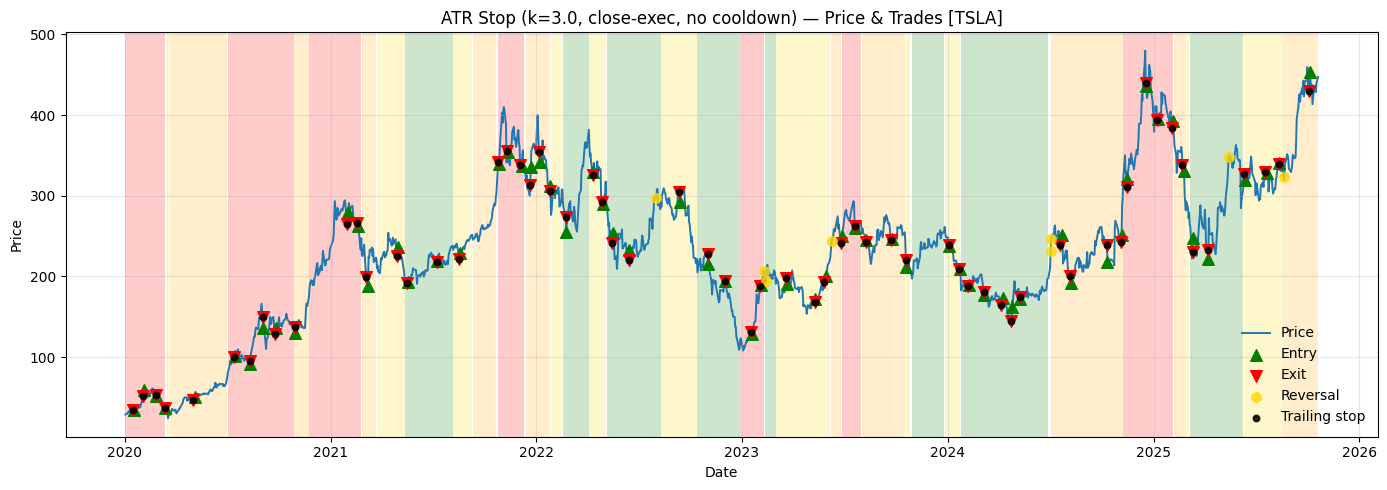

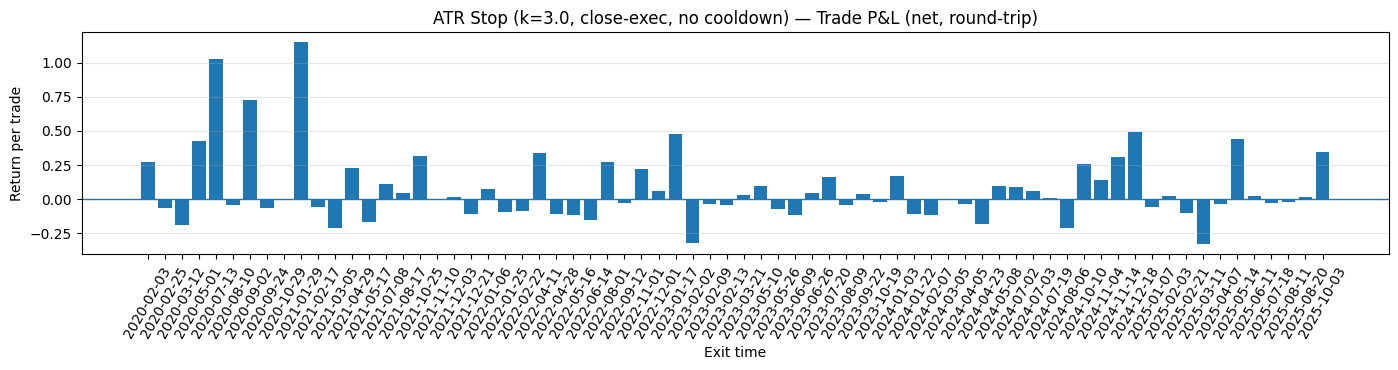

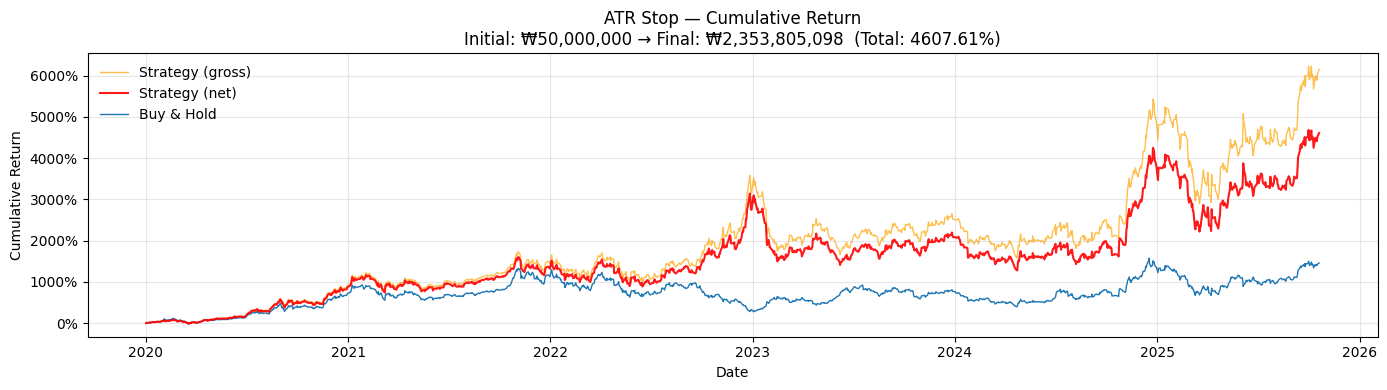

                value
CAGR           1.0153
Sharpe(ann.)   1.4359
Sortino(ann.)  2.1587
Calmar         1.7676
MaxDD         -0.5744
DailyMean      0.0036
DailyStd       0.0393


In [451]:
my_config = BTConfig(init_capital=50_000_000, fee_bps=20, slip_bps=0, allow_shorts=True)

bt = run_backtest(
    df_out,
    strategies={1: strat_momentum, 2: strat_momentum, 3: strat_mean_reversion, 4: strat_mean_reversion},
    start="2020-01-01", end="2025-10-20",
    warmup_bars=200,
    exec_shift=1,
    k_atr=3.0, trail_pct=None, cool_off_days=0,
    execute_on_trigger_close=True,
    min_gain_to_trail_atr=0.3,      # 이익이 0.3×ATR 이상
    arm_after_bars=10,               # 또는 진입 후 하나의 캔들 경과 (1-day라는 뜻)
    initial_k_atr=2.0,              # 진입가 ± 2×ATR(진입시)
    initial_pct=None,               # 혹은 퍼센트 기반 사용 가능
    hard_stop_use_entry_atr=True,   # 진입 시 ATR 고정
    config=my_config
)

plot_backtest_with_trades_rainbow(bt, df_out, price_col="Close",
                                  title_prefix="ATR Stop (k=3.0, close-exec, no cooldown)",
                                  shade_alpha=0.2, show_regime=True, ticker="TSLA")

plot_cum_return_after(bt, title="ATR Stop — Cumulative Return", show_buyhold=True)
print(bt["summary"].round(4))

In [449]:
# === 전략/레짐 기여도(Attribution) 테이블 만들기 ===
def strategy_attribution(bt: dict,
                         df_out: pd.DataFrame,
                         *,
                         regime_col: str = "regime",
                         strategies: Optional[Dict[int, Callable]] = None,
                         name_map: Optional[Dict[int, str]] = None,
                         periods_per_year: int = 252) -> pd.DataFrame:
    """
    bt: run_backtest(...) or backtest_regime_switch(...) 결과 dict
    df_out: 인덱스 정렬된 원본 데이터프레임 (regime_col 포함)
    regime_col: 레짐 레이블 컬럼명 (정수 레짐 또는 {'Momentum','MeanReversion','RandomWalk'})
    strategies: K-regimes 모드에서 사용한 {regime_id: strategy_func}
    name_map: {regime_id: '표시할 전략명'} (없으면 함수.__name__로 표시)
    
    반환: 전략별 요약(총수익, CAGR, Sharpe, MaxDD, 기여도 %, 활동일수 등)
    """
    import numpy as np
    import pandas as pd

    res = bt["result"].copy()
    res.index = pd.DatetimeIndex(res.index)
    net = pd.to_numeric(res["net"], errors="coerce").fillna(0.0).astype(float)
    price = pd.to_numeric(res["price"], errors="coerce").astype(float)

    # 1) 레짐 시리즈 준비 (정수 or 문자열)
    reg = df_out.reindex(res.index)[regime_col]
    # 문자열이면 {-1,0,1}로 매핑
    if not np.issubdtype(reg.dtype, np.integer):
        def _norm(x):
            s = str(x).strip().lower().replace("_","")
            if s in ("momentum","momo"): return 1
            if s in ("meanreversion","mean-reversion","mr"): return -1
            if s in ("randomwalk","rw"): return 0
            return np.nan
        reg = reg.map(_norm).astype("float").astype("Int64")

    # 2) 레짐→전략명 매핑
    # tri-signal 기본 이름
    strat_name_default = {1: "Momentum", -1: "MeanReversion", 0: "RandomWalk"}
    # K-regimes이면 strategies 있으면 함수명으로
    name_by_reg = {}
    for r in sorted(set(reg.dropna())):
        if name_map and r in name_map:
            name_by_reg[r] = name_map[r]
        elif strategies and (r in strategies):
            name_by_reg[r] = getattr(strategies[r], "__name__", f"Strategy_{r}")
        else:
            name_by_reg[r] = strat_name_default.get(int(r), f"Strategy_{r}")

    # 3) 전략별 수익 시리즈(비용 포함 net를 해당 전략 활성 구간에만 할당)
    df_parts = {}
    for r, nm in name_by_reg.items():
        mask = (reg.astype("float") == float(r)).reindex(res.index).fillna(False)
        df_parts[nm] = (net.where(mask, 0.0))

    parts = pd.DataFrame(df_parts)
    parts["Unattributed"] = net - parts.sum(axis=1)  # 이론상 0이어야 함(정상)
    
    # 4) 요약 통계
    def _stats(s: pd.Series) -> dict:
        s = s.astype(float)
        one = (1 + s).cumprod()
        if len(one) < 2:
            return {"TotalRet": 0.0, "CAGR": 0.0, "Sharpe(ann.)": np.nan,
                    "MaxDD": 0.0, "DaysActive": int((s!=0).sum())}
        n_days = (one.index[-1] - one.index[0]).days if isinstance(one.index, pd.DatetimeIndex) else len(one)
        years = max(n_days/365.25, 1e-9)
        cagr = (one.iloc[-1]/one.iloc[0])**(1/years) - 1
        mu, sd = s.mean(), s.std(ddof=0)
        sharpe = (mu / sd) * np.sqrt(periods_per_year) if sd > 0 else np.nan
        mdd = (one/one.cummax() - 1).min()
        return {"TotalRet": (one.iloc[-1] - one.iloc[0]) / max(one.iloc[0], 1e-12),
                "CAGR": cagr, "Sharpe(ann.)": sharpe, "MaxDD": mdd,
                "DaysActive": int((s!=0).sum())}

    rows = []
    total_net = (1 + net).prod() - 1.0
    for nm in df_parts.keys():
        st = _stats(parts[nm])
        rows.append({"Strategy": nm, **st})

    out = pd.DataFrame(rows).set_index("Strategy").sort_values("TotalRet", ascending=False)
    out["Contribution(%)"] = 100 * out["TotalRet"] / max(total_net, 1e-12)
    out.loc["__TOTAL__", ["TotalRet","CAGR","Sharpe(ann.)","MaxDD","DaysActive","Contribution(%)"]] = [
        total_net,
        _stats(net)["CAGR"],
        _stats(net)["Sharpe(ann.)"],
        _stats(net)["MaxDD"],
        int((net!=0).sum()),
        100.0
    ]
    return out, parts


In [450]:
attr_table, attr_series = strategy_attribution(
    bt, df_out,
    regime_col="regime",
    strategies={1: strat_momentum, 2: strat_momentum,
                3: strat_mean_reversion, 4: strat_mean_reversion},
    name_map={1:"Momentum(1)", 2:"Momentum(2)", 3:"MR(3)", 4:"MR(4)"}
)

attr_table

,TotalRet,CAGR,Sharpe(ann.),MaxDD,DaysActive,Contribution(%)
Strategy,,,,,,
Momentum(1),6.617257,0.419275,1.238104,-0.397745,341.0,2.998381
Momentum(2),5.048317,0.363934,1.111608,-0.354767,387.0,2.287469
MR(4),4.776845,0.353175,1.055740,-0.231035,437.0,2.164461
MR(3),-0.190123,-0.035712,-0.039620,-0.491236,293.0,-0.086148
__TOTAL__,220.694385,1.525925,1.814065,-0.451233,1458.0,100.000000
